# Análisis supervisado

In [298]:
#Cargar dataset

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [299]:
import jinja2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.options.display.max_columns = None

### Dataset

Clientes que se fueron en el último mes: la columna se llama Churn

Servicios a los que se ha suscrito cada cliente: teléfono, múltiples líneas, internet, seguridad en línea, copia de seguridad en línea, protección de dispositivos, soporte técnico y transmisión de TV y películas.

Información de la cuenta del cliente: cuánto tiempo ha sido cliente, contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales.

Información demográfica sobre los clientes: género, rango de edad y si tienen pareja y dependientes.

### EDA

In [300]:
# Mostramos las primeras filas
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No        

In [301]:
print("Forma del dataset:", df.shape)
print("\nInformación del dataset:")
df.info()

Forma del dataset: (7043, 21)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null  

In [302]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [303]:
print("\nValores únicos en columnas categóricas:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")
    print(f"Número de valores únicos: {df[col].nunique()}\n")


Valores únicos en columnas categóricas:
customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Número de valores únicos: 7043

gender: ['Female' 'Male']
Número de valores únicos: 2

Partner: ['Yes' 'No']
Número de valores únicos: 2

Dependents: ['No' 'Yes']
Número de valores únicos: 2

PhoneService: ['No' 'Yes']
Número de valores únicos: 2

MultipleLines: ['No phone service' 'No' 'Yes']
Número de valores únicos: 3

InternetService: ['DSL' 'Fiber optic' 'No']
Número de valores únicos: 3

OnlineSecurity: ['No' 'Yes' 'No internet service']
Número de valores únicos: 3

OnlineBackup: ['Yes' 'No' 'No internet service']
Número de valores únicos: 3

DeviceProtection: ['No' 'Yes' 'No internet service']
Número de valores únicos: 3

TechSupport: ['No' 'Yes' 'No internet service']
Número de valores únicos: 3

StreamingTV: ['No' 'Yes' 'No internet service']
Número de valores únicos: 3

StreamingMovies: ['No' 'Yes' 'No internet service']
Número de valores ú

In [304]:
print("\nEstadísticas descriptivas de variables numéricas:")
print(df.describe())


Estadísticas descriptivas de variables numéricas:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


SeniorCitizen es una variable binaria (media = 0.16, max = 1), lo que indica que solo el 16.2% de los clientes son considerados "adultos mayores".

Tenure (antigüedad en meses)  tiene una media de 32.4 meses, pero con una dispersión amplia (DE = 24.6), reflejando una distribución desigual (mediana = 29, pero 25% tiene ≤9 meses y 75% ≤55 meses).

MonthlyCharges (cargos mensuales) promedia $64.76, con una desviación estándar de $30.09, mostrando una amplia variabilidad (mínimo = $18.25, máximo = $118.75). La mediana ($70.35) supera a la media, sugiriendo una posible asimetría hacia valores más bajos. Estos datos podrían indicar una base de clientes con perfiles heterogéneos en términos de permanencia y gastos.

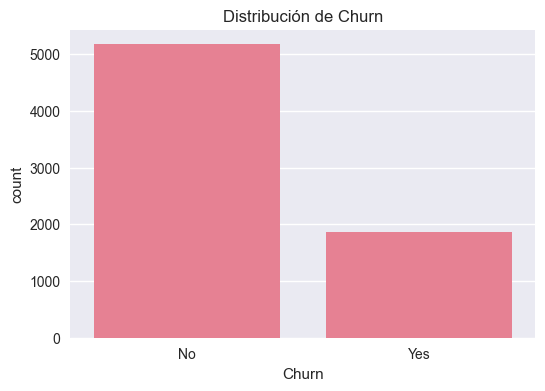

In [305]:
#Análisis de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.show()

El gráfico muestra la distribución de la variable Churn (abandono de clientes) en un conjunto de datos. Se observa una marcada diferencia entre las categorías: la mayoría de los clientes no han abandonado el servicio ("No", aproximadamente 5,000 casos), mientras que una minoría sí lo ha hecho ("Yes", alrededor de 1,500-2,000 casos estimados).

### Limpieza y preparación de datos

In [306]:
#Convertir TotalCharges a númerico
df['TotalCharges']= pd.to_numeric(df['TotalCharges'], errors='coerce')

In [307]:
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [308]:
#Convertir SeniorCitizen a categórica para mejor interpretación

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [309]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


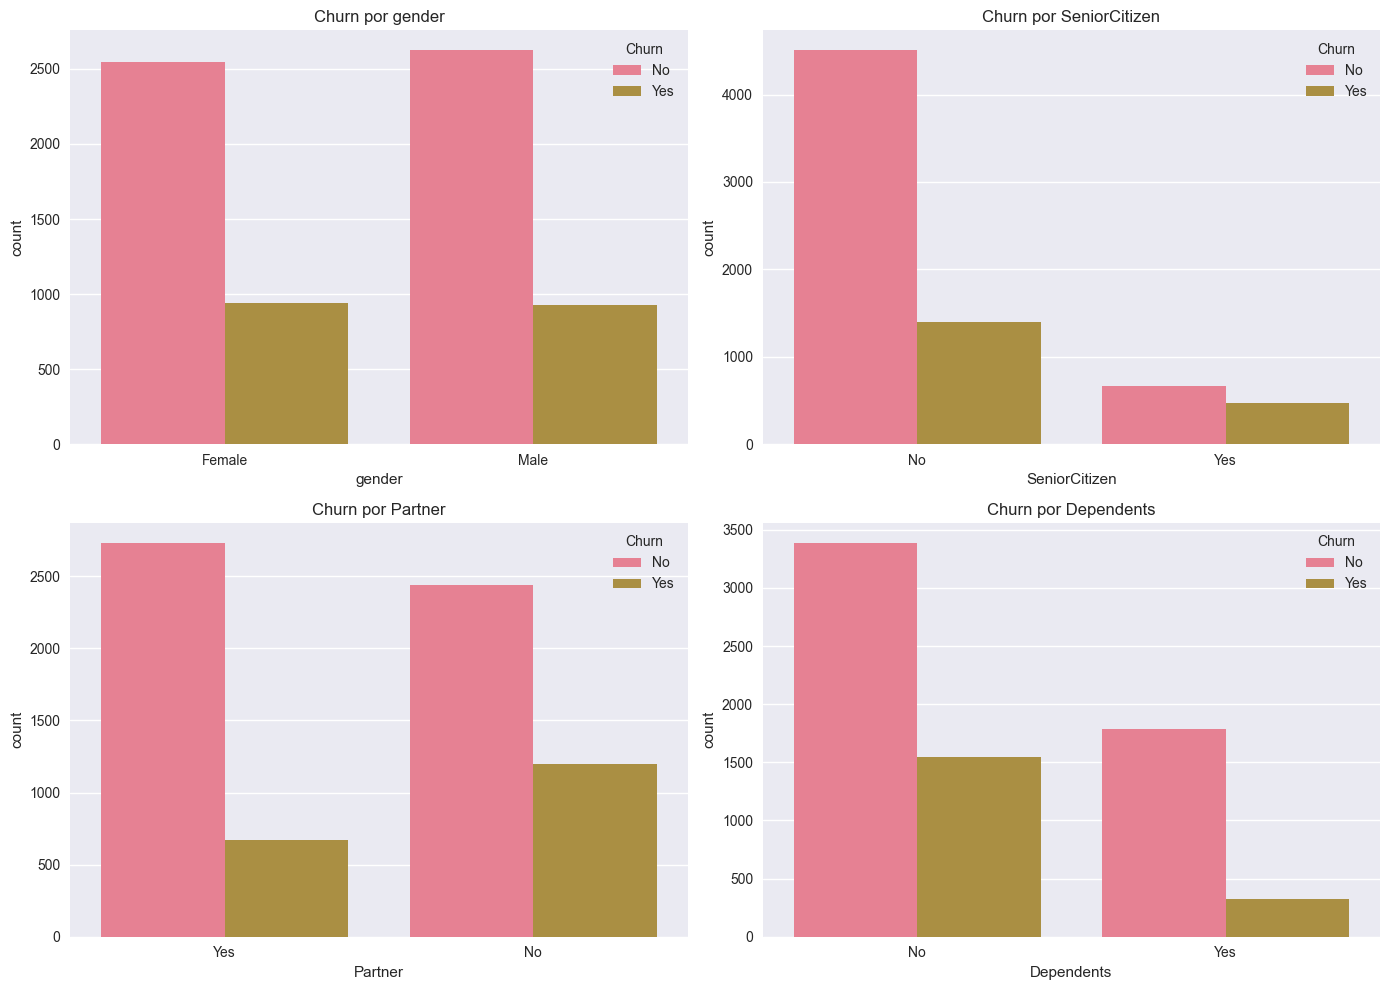

In [310]:
# Análisis de características demográficas
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(demographic_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'Churn por {feature}')
plt.tight_layout()
plt.show()

El gráfico "Churn per gender" muestra la distribución del abandono de clientes (Churn) segmentado por género. Se observa que la proporción de abandono (Yes) es similar entre ambos géneros, lo que sugiere que el género no es un factor determinante en la tasa de Churn.

En "Churn per Partner", se analiza si tener pareja influye en el abandono. Los clientes sin pareja (No) parecen tener una tasa de Churn ligeramente más alta que aquellos con pareja (Yes), lo que podría indicar que la estabilidad personal (o acceso a planes compartidos) reduce la probabilidad de abandono.

"Churn per SeniorCitizen" revela que los clientes mayores (SeniorCitizen = Yes) presentan una proporción significativamente mayor de abandono en comparación con los no mayores (No). Esto podría deberse a factores como dificultades con la tecnología, preferencia por servicios más simples o sensibilidad a precios.

"Churn per Dependents" sugiere que los clientes sin dependientes (No) tienen una mayor tasa de Churn que aquellos con dependientes (Yes). Esto podría relacionarse con una mayor necesidad de mantener el servicio por responsabilidades familiares o beneficios compartidos.

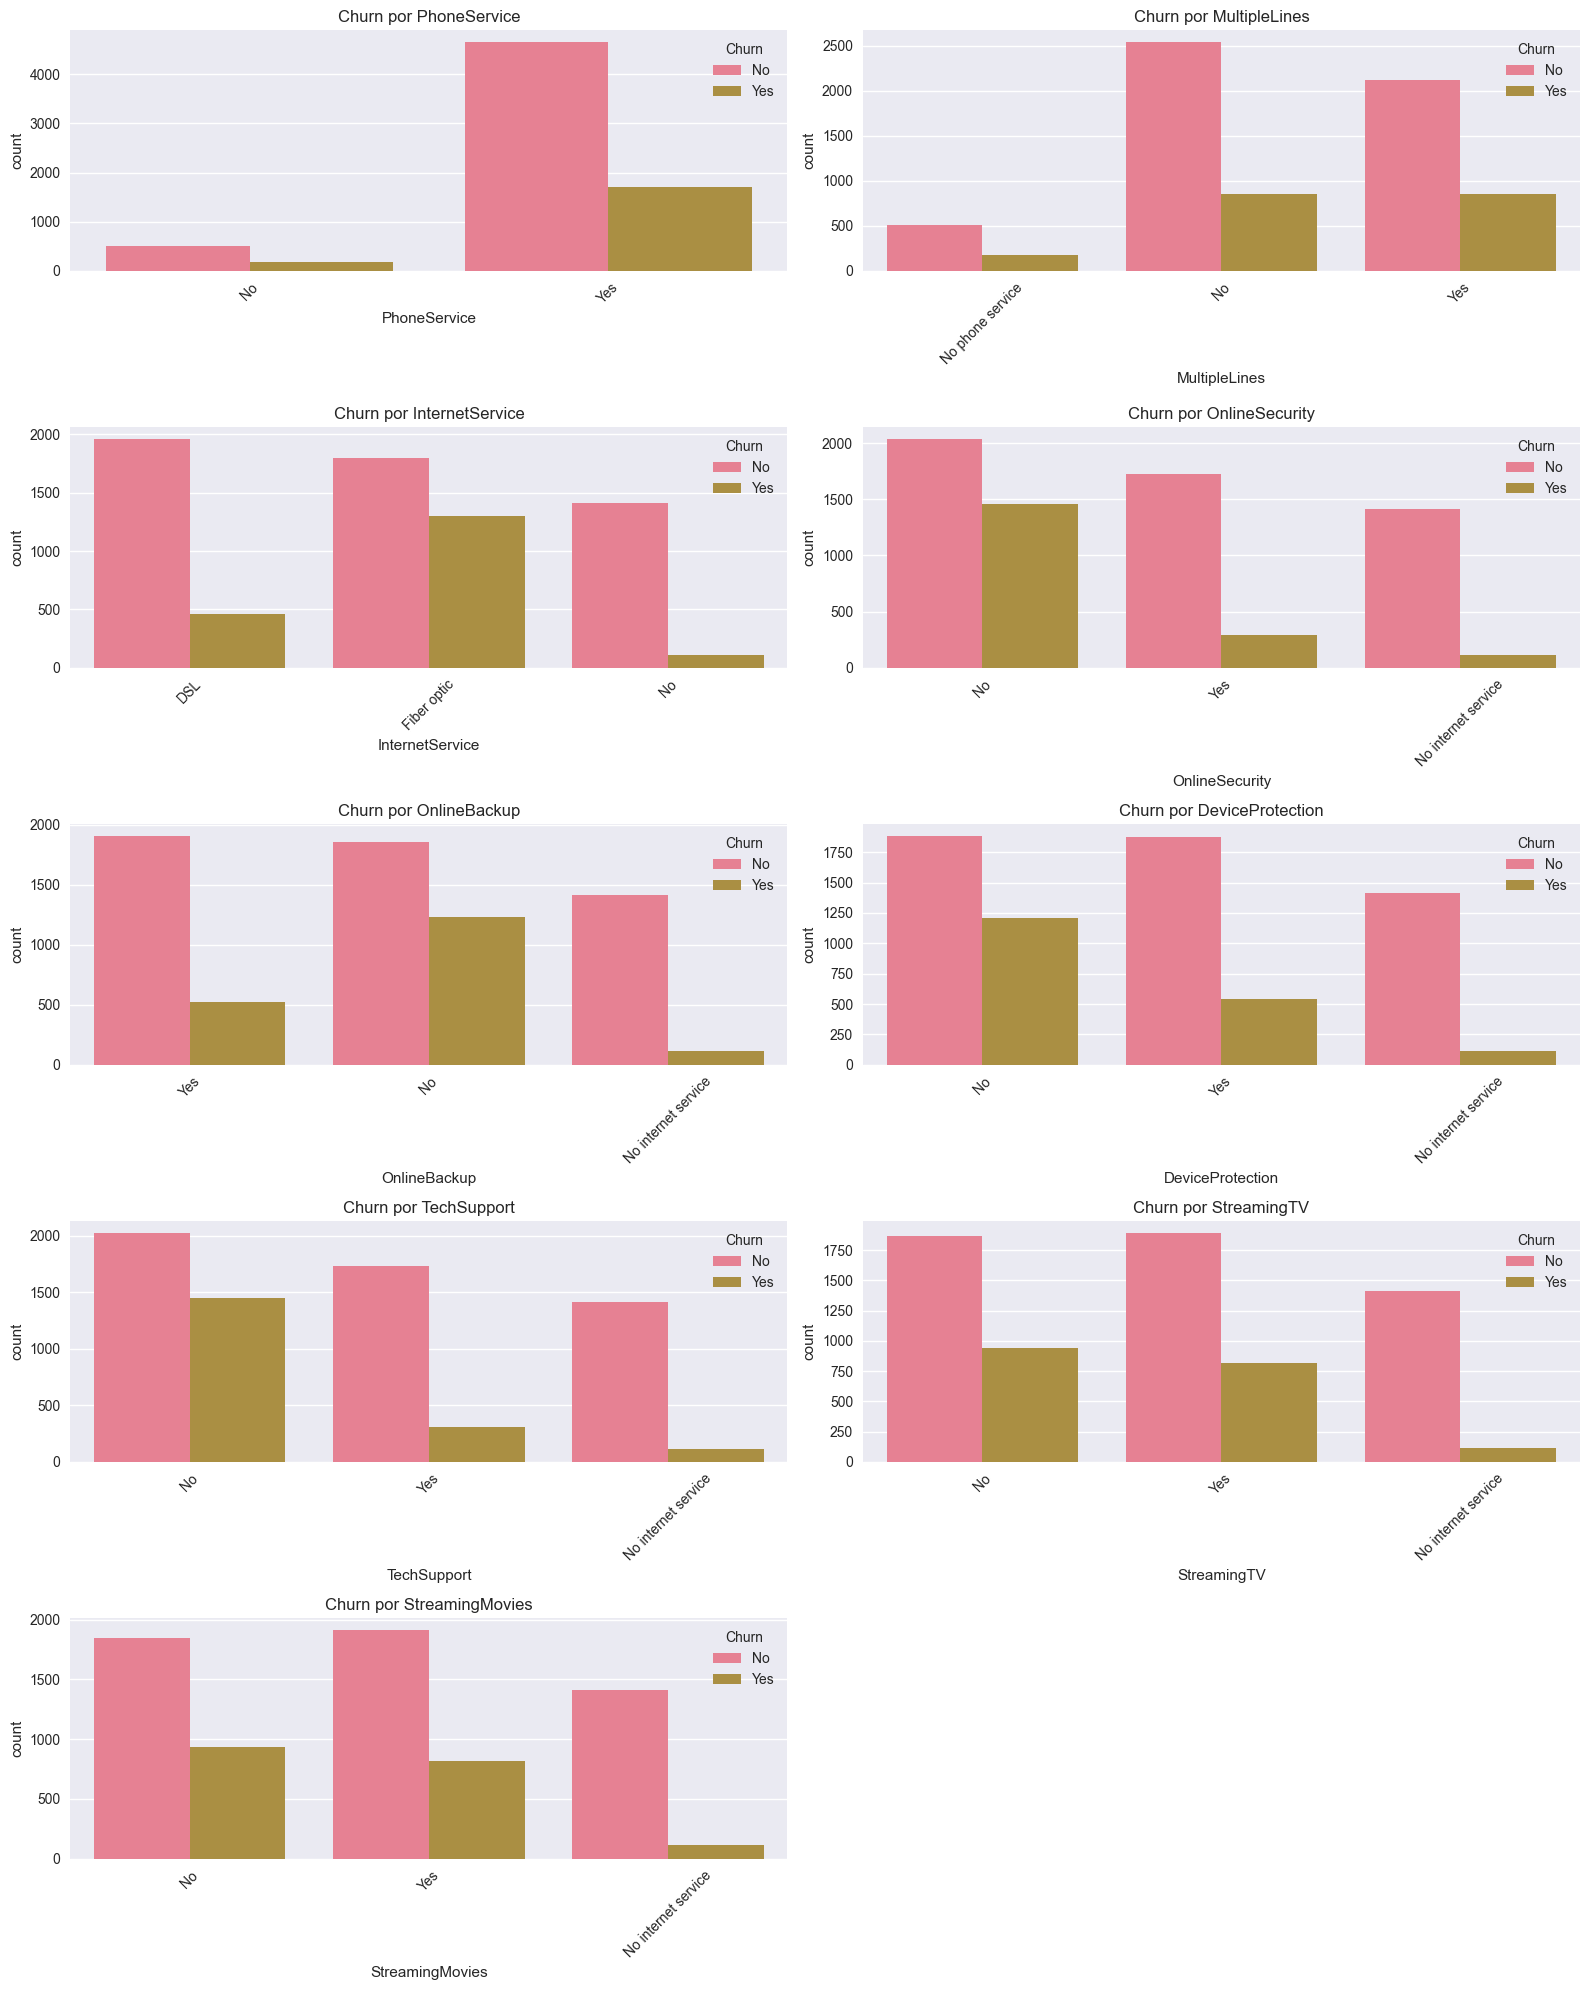

In [311]:
# Análisis de servicios contratados
service_features = ['PhoneService', 'MultipleLines', 'InternetService', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

plt.figure(figsize=(16, 20))
for i, feature in enumerate(service_features, 1):
    plt.subplot(5, 2, i)
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'Churn por {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Servicios críticos como internet (fibra) y la falta de soporte técnico/seguridad son factores de riesgo clave para el Churn.

Los servicios premium (ej. múltiples líneas o streaming) no necesariamente retienen clientes, y en algunos casos podrían aumentar el abandono por costos o expectativas no cumplidas.

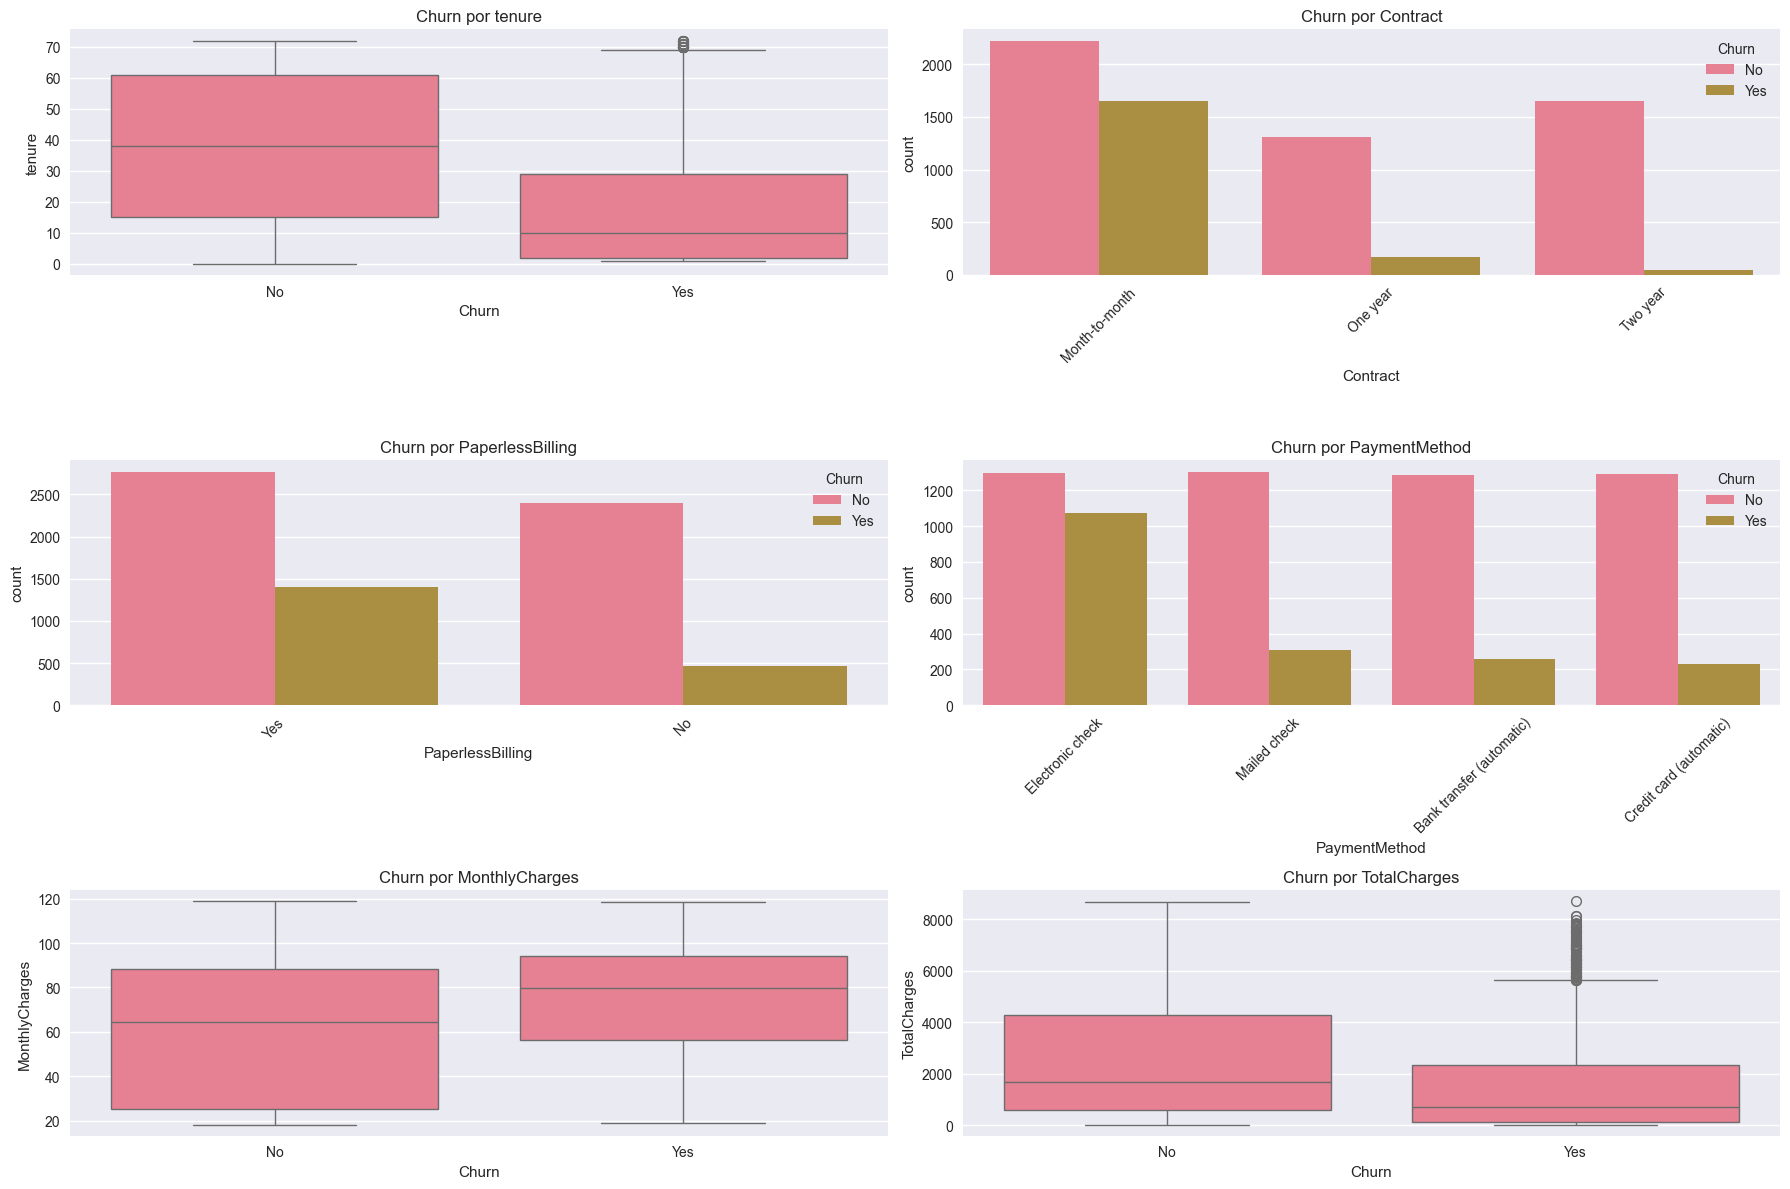

In [312]:
# Análisis de información de cuenta
account_features = ['tenure', 'Contract', 'PaperlessBilling', 
                   'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(account_features, 1):
    plt.subplot(3, 2, i)
    if feature in ['tenure', 'MonthlyCharges', 'TotalCharges']:
        sns.boxplot(x='Churn', y=feature, data=df)
    else:
        sns.countplot(x=feature, hue='Churn', data=df)
        plt.xticks(rotation=45)
    plt.title(f'Churn por {feature}')
plt.tight_layout()
plt.show()

La mayoría de los clientes que abandonan tienen contrato “Month-to-month” (mes a mes).Churn es muy bajo en contratos de un año o dos años.

El método “Electronic check” está asociado a una mayor tasa de abandono. Métodos automáticos como tarjeta de crédito o transferencia bancaria están asociados con menor churn.

Los clientes que se van tienden a tener cargos mensuales ligeramente más altos.

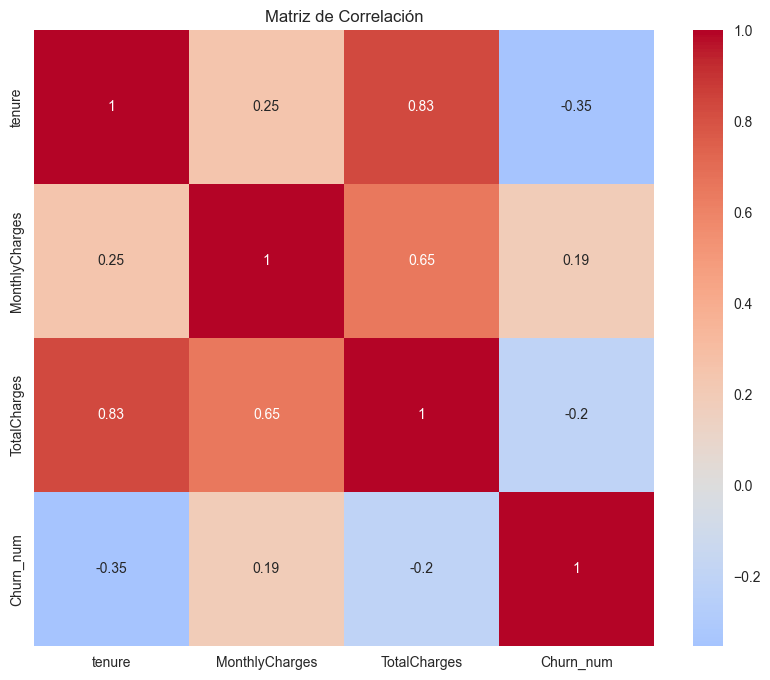

In [313]:
# Convertir 'Churn' a numérico para análisis de correlación
df['Churn_num'] = df['Churn'].map({'No': 0, 'Yes': 1})

numeric_df = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_num']]
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


### Preprocesamiento de datos

In [314]:
# Eliminar columna customerID
df.drop('customerID', axis=1, inplace=True)

In [333]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [315]:
# Convertir SeniorCitizen de vuelta a numérico
df['SeniorCitizen'] = df['SeniorCitizen'].map({'No': 0, 'Yes': 1})

In [ ]:
# Definir variables
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                      'PhoneService', 'MultipleLines', 'InternetService',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies',
                      'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Modelos

In [346]:
models_config = [
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'Árbol de Decisión',
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'decisiontreeclassifier__max_depth': [None, 10, 20],
            'decisiontreeclassifier__min_samples_split': [2, 5]
        }
    },
    {
        'name': 'Regresión Logística',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'logisticregression__C': [0.1, 1, 10],
            'logisticregression__penalty': ['l2']
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [None, 10]
        }
    }
]

In [363]:
for config in models_config:
    print(f"\n🔹 Entrenando {config['name']}...")
    try:
        pipeline = make_imb_pipeline(
            preprocessor,
            SMOTE(random_state=42),
            config['model']
        )
        grid = GridSearchCV(pipeline, config['params'], cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]
        results[config['name']] = {
            'model': grid.best_estimator_,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, pos_label='Yes'),
            'recall': recall_score(y_test, y_pred, pos_label='Yes'),
            'f1': f1_score(y_test, y_pred, pos_label='Yes'),
            'roc_auc': roc_auc_score(y_test.map({'No': 0, 'Yes': 1}), y_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'best_params': grid.best_params_,
            'classification_report': classification_report(y_test, y_pred)
        }
        print(f"✅ {config['name']} completado correctamente")
    except Exception as e:
        print(f"❌ Error en {config['name']}: {str(e)}")
        continue


🔹 Entrenando KNN...
✅ KNN completado correctamente

🔹 Entrenando Árbol de Decisión...
✅ Árbol de Decisión completado correctamente

🔹 Entrenando Regresión Logística...
✅ Regresión Logística completado correctamente

🔹 Entrenando Random Forest...
✅ Random Forest completado correctamente


In [365]:
print("\nModelos entrenados exitosamente:", list(results.keys()))


Modelos entrenados exitosamente: ['Random Forest', 'KNN', 'Árbol de Decisión', 'Regresión Logística']


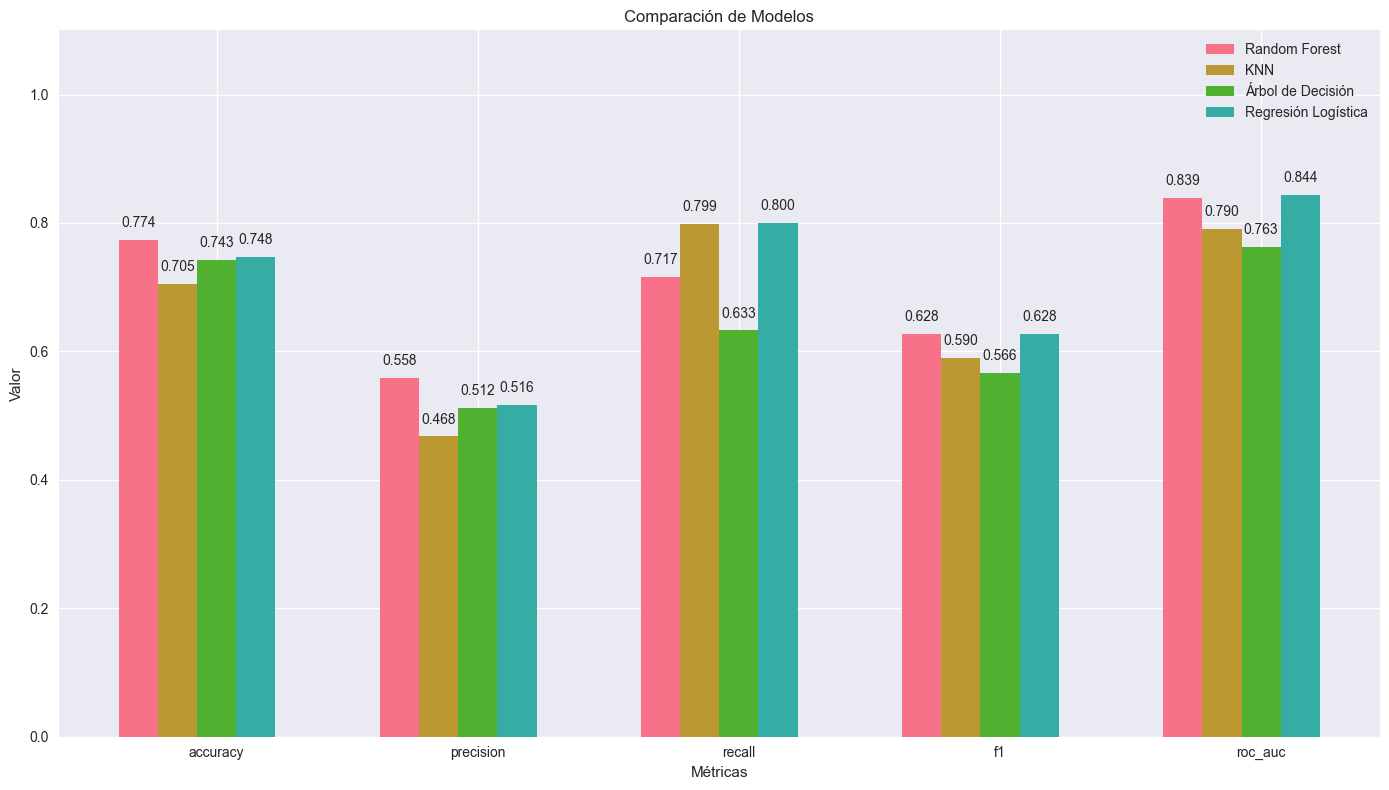

In [370]:
# Visualización garantizada de todos los modelos
if len(results) > 0:
    # Gráfico comparativo
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    model_names = list(results.keys())
    
    plt.figure(figsize=(14, 8))
    bar_width = 0.15
    index = np.arange(len(metrics))
    
    for i, model in enumerate(model_names):
        values = [results[model][m] for m in metrics]
        plt.bar(index + i*bar_width, values, bar_width, label=model)
    
    plt.xlabel('Métricas')
    plt.ylabel('Valor')
    plt.title('Comparación de Modelos')
    plt.xticks(index + bar_width*len(models_config)/2, metrics)
    plt.legend()
    plt.ylim(0, 1.1)
    
        # Añadir valores
    for i, model in enumerate(model_names):
        for j, metric in enumerate(metrics):
            plt.text(index[j] + i*bar_width, results[model][metric] + 0.02, 
                    f"{results[model][metric]:.3f}", ha='center')
    
    plt.tight_layout()
    plt.show()

#### Mejor modelo

In [378]:
# Crear DataFrame comparativo
comparison_df = pd.DataFrame([
    {
        'Modelo': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1'],
        'ROC AUC': res['roc_auc']
    }
    for name, res in results.items()
]).sort_values('ROC AUC', ascending=False)

# Seleccionar el mejor modelo basado en ROC AUC (métrica clave para problemas desbalanceados)
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print(f"⚡ **MEJOR MODELO SELECCIONADO:** {best_model_name}")
print(f"📊 **Métricas clave:**")
print(f"- Accuracy: {best_metrics['accuracy']:.4f}")
print(f"- Precision: {best_metrics['precision']:.4f}")
print(f"- Recall: {best_metrics['recall']:.4f}")
print(f"- F1-Score: {best_metrics['f1']:.4f}")
print(f"- ROC AUC: {best_metrics['roc_auc']:.4f}")

display(comparison_df.style
        .background_gradient(cmap='Blues', subset=['Accuracy', 'ROC AUC'])
        .highlight_max(color='lightgreen', subset=['Accuracy', 'ROC AUC']))

⚡ **MEJOR MODELO SELECCIONADO:** Regresión Logística
📊 **Métricas clave:**
- Accuracy: 0.7478
- Precision: 0.5161
- Recall: 0.8004
- F1-Score: 0.6275
- ROC AUC: 0.8438


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC AUC
3,Regresión Logística,0.747752,0.516092,0.800357,0.627533,0.843814
0,Random Forest,0.774255,0.558333,0.716578,0.627635,0.838820
1,KNN,0.705159,0.467641,0.798574,0.589862,0.790236
2,Árbol de Decisión,0.742546,0.512266,0.632799,0.566188,0.763292


#### Curvas ROC

c:\Users\angel\.venvs\cienciadedatosI\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


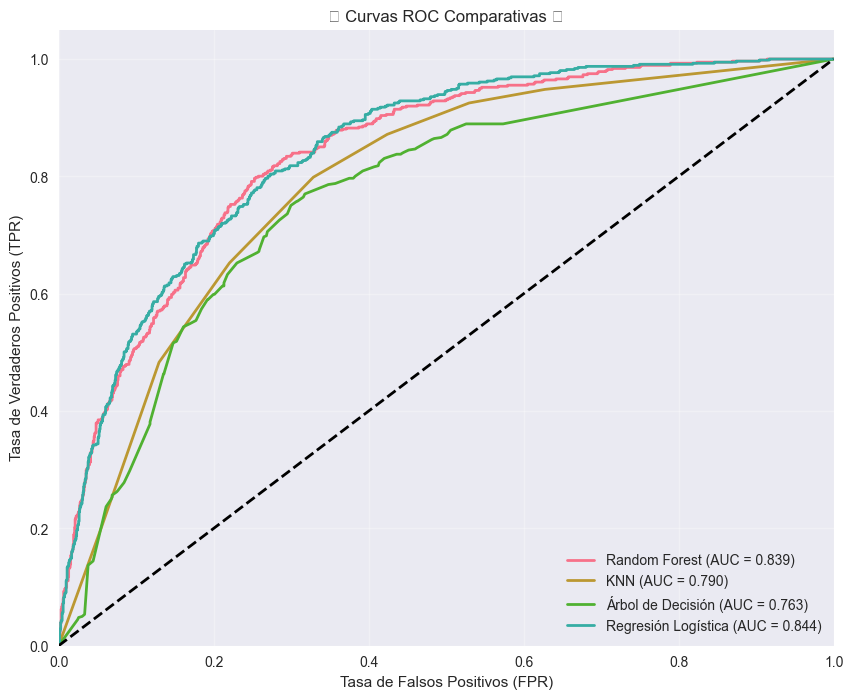

In [381]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Curva para cada modelo
for name, res in results.items():
    y_proba = res['model'].predict_proba(X_test)[:, 1]
    # Convertir y_test a 0/1 para roc_curve
    fpr, tpr, _ = roc_curve(y_test.map({0: 0, 1: 1, 'No': 0, 'Yes': 1}), y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('🔷 Curvas ROC Comparativas 🔷')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

c:\Users\angel\.venvs\cienciadedatosI\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


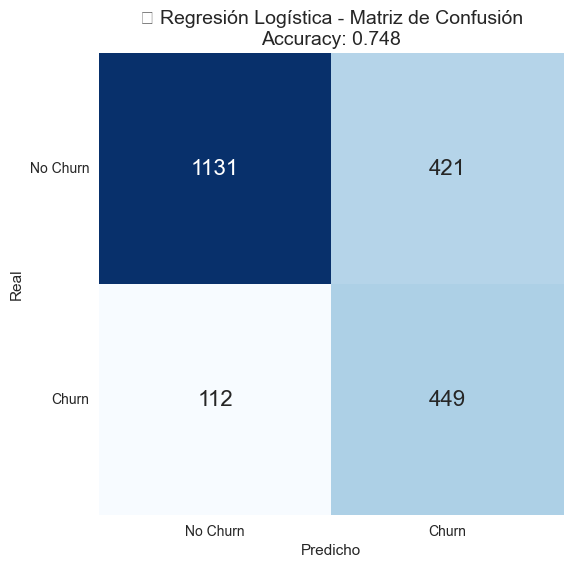

In [382]:
#Matriz de confusión del mejor modelo

plt.figure(figsize=(6, 6))
sns.heatmap(best_metrics['confusion_matrix'], 
            annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 16}, cbar=False)

plt.title(f'✅ {best_model_name} - Matriz de Confusión\nAccuracy: {best_metrics["accuracy"]:.3f}', fontsize=14)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], ['No Churn', 'Churn'])
plt.yticks([0.5, 1.5], ['No Churn', 'Churn'], rotation=0)
plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_32260\3187606101.py:17: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\angel\.venvs\cienciadedatosI\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


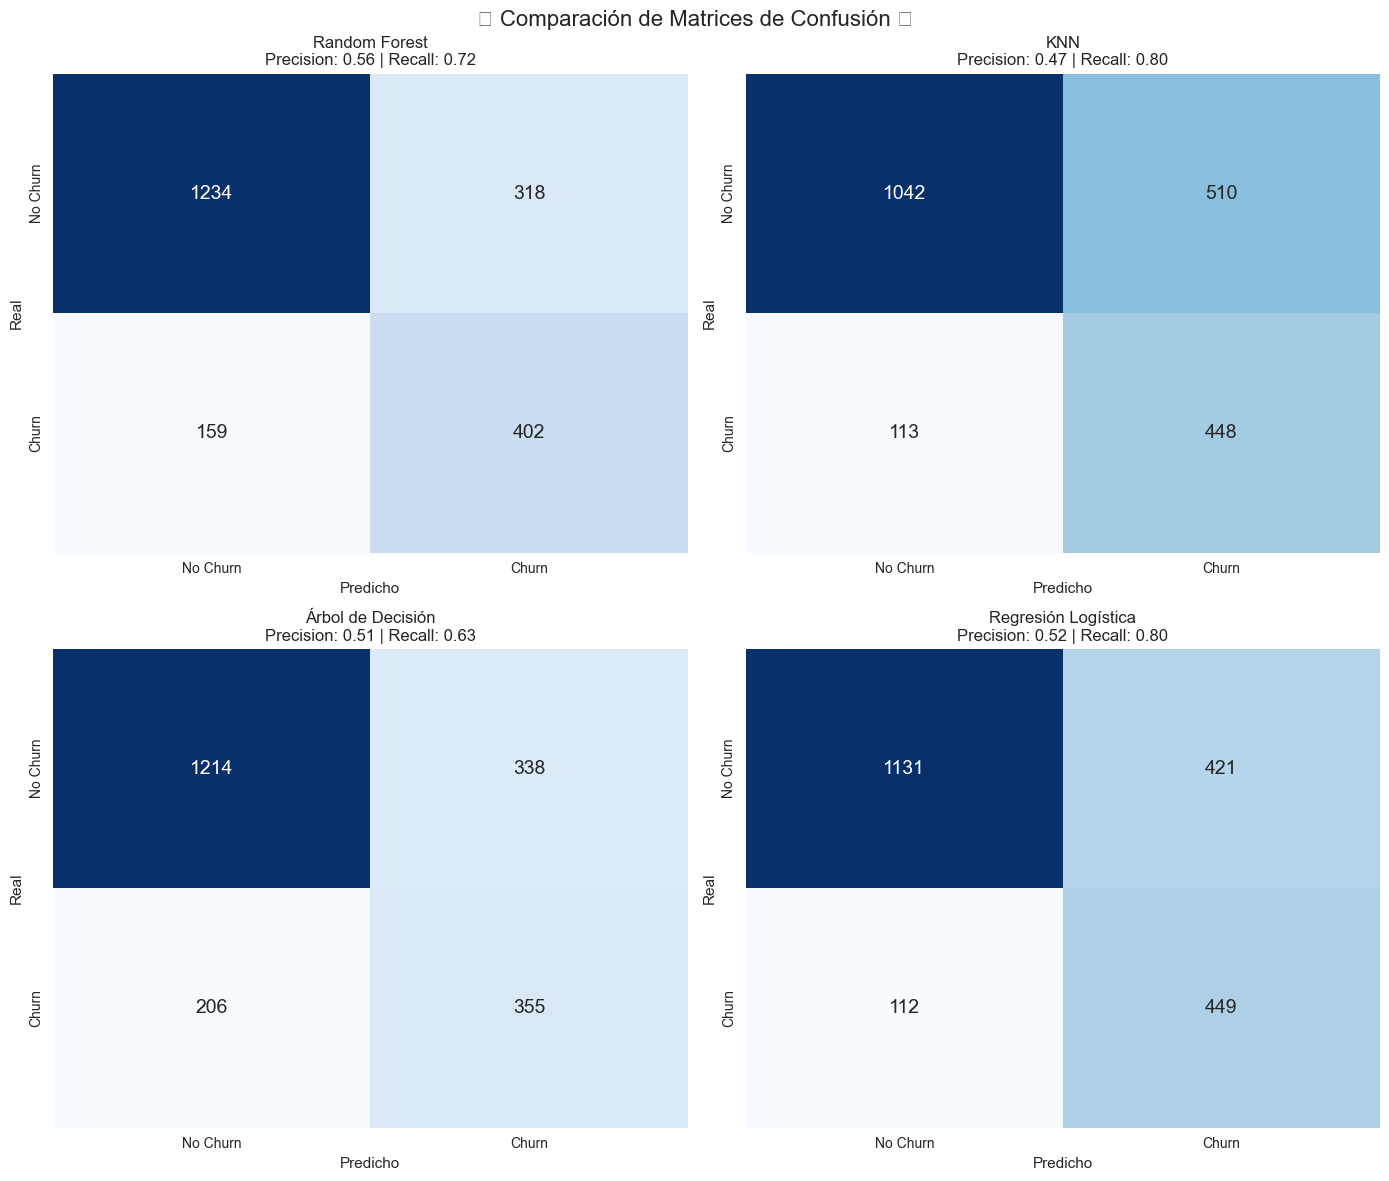

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for (name, res), ax in zip(results.items(), axes):
    sns.heatmap(res['confusion_matrix'], 
                annot=True, fmt='d', cmap='Blues', 
                ax=ax, cbar=False,
                annot_kws={"size": 14})
    
    ax.set_title(f'{name}\nPrecision: {res["precision"]:.2f} | Recall: {res["recall"]:.2f}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_yticklabels(['No Churn', 'Churn'])

plt.suptitle('🔷 Comparación de Matrices de Confusión 🔷', fontsize=16)
plt.tight_layout()
plt.show()